In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mesa import Agent, Model
from mesa.datacollection import DataCollector
import pandas as pd

In [2]:
#data from https://fred.stlouisfed.org/series/REAINTRATREARAT10Y#0
#the data is the interest rate per month for all 120 months starting from 2013 till the end of 2023

df = pd.read_csv('data_interest_rate.csv')
df2 = df.drop([df.index[120]])
df3 = df2["interest_rate"]
df3

df_inflation = pd.read_csv('inflation_data.csv')
df_inflation = df_inflation.drop([df_inflation.index[120]])
df_inflation = df_inflation["T10YIE"]
df_inflation

#global variables

HOUSE_SIZES = ["XS", "S", "M", "L", "XL"]
# location miss veranderen voor staten en evt met dict en kans/ verhouding inwoners erbij -> geen idee hoe.
LOCATIONS = ["N", "E", "S", "W"]

INTEREST_RATE = list(df3)
INFLATON = list(df_inflation)

# scratch
# for location the following can maybe be used (comes from https://gist.github.com/JeffPaine/3083347):
west = ["CA", "OR", "WA", "NV", "ID", "UT", "CO", "WY", "MT"]
midwest = ["ND", "SD", "NE", "KS", "MN", "IA", "MO", "WI", "IL", "IN", "MI", "OH"]
southwest = ["AZ", "NM", "TX", "OK"]
southeast = ["AR", "LA", "MS", "TN", "AL", "KY", "GA", "WV", "VA", "NC", "SC", "FL", "MD", "DE"]
northeast = ["CT", "DC", "HI", "ME", "MA", "NH", "NJ", "NY", "PA", "RI", "VT"]
noncontig = ["HI", "AK"]

**Plan:**

  Echte situatie van een jaar of 10 proberen te maken.

  Vervolgens die situatie gebruiken om interest rates aan te passen. 

**Hoe?**

  Duidelijke regels hebben voor koop en verkoop.

  Uitbreiden met bijvoorbeeld locatie, type huis, grote huis -> kan miss met score voor voorkeur.

  Hoeveelheid kopers en verkopers kan impact hebben op kosten van huis.

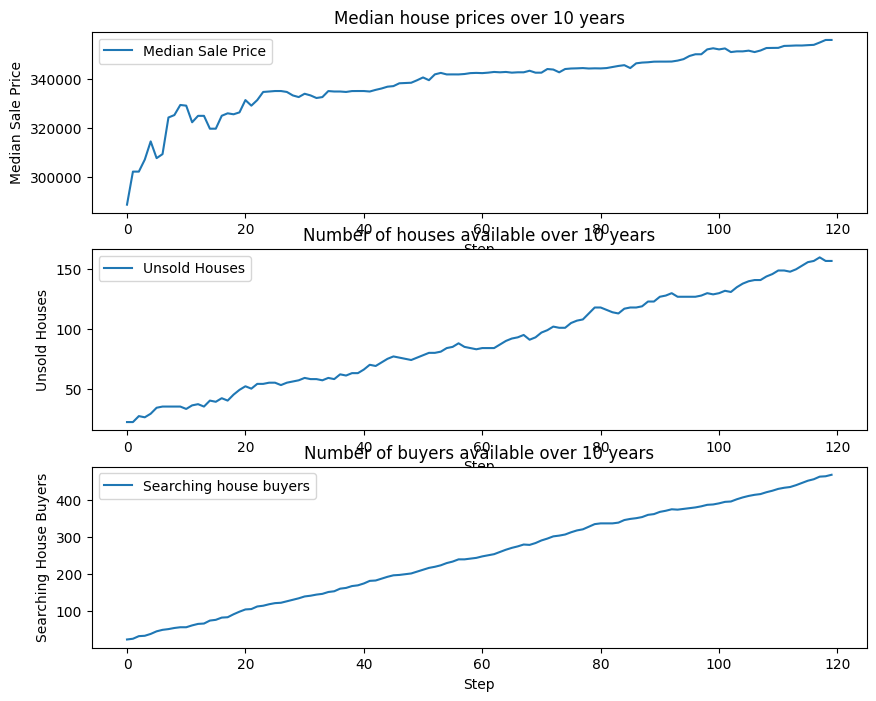

In [7]:
class BuyerAgent(Agent):
    def __init__(self, model, interest_rate, inflation):
        super().__init__(model)

        # assumption people are willing to pay between 30 and 50 % of salary. -> no source yet
        interest_rate_monthly = interest_rate / 100 / 12
        #Us avarage of percentage to mortage in US is 25 - 30 % -> no source yet
        mean_percentage = 0.275
        std_percentage = 0.25
        willing_to_pay = np.clip(np.random.normal(mean_percentage, std_percentage), 0.1, 1)
        
        #assumption paying mortage in 30 years. 30 * 12 = 360 payments.
        payments = 12 * 30
        mean_salary = int(4354 * (1 + inflation / 100))
        std_dev_salary = 1000
        #np.clip only gives numbers between the two given numbers, in this case 1000 and 10000
        self.salary = np.clip(int(np.random.normal(mean_salary, std_dev_salary)), 1000 * (1 + inflation / 100), 10000 * (1 + inflation / 100))

        
        # M = P * (r * (1 + r)^360) / ((1 + r)^360 - 1) based on https://www.bankrate.com/mortgages/mortgage-calculator/#calculate-mortgage-payment
        # P is principal loan amount, M is monthly payment (here max monthly payment) and r = interest rate monthly
        # Omgerekend = P = M / (r * (1 + r)^360) / ((1 + r)^360 - 1)
        M = self.salary * willing_to_pay
        self.budget = (M * ((1 + interest_rate_monthly)**payments - 1)) / (interest_rate_monthly * (1 + interest_rate_monthly)**payments)

        self.preference_size = np.random.choice(HOUSE_SIZES)
        self.preference_location = np.random.choice(LOCATIONS)

        #variables to keep track of information
        self.months = 0
        self.house_bought = False

    def buy_house(self, model):
        """Function that buys a house"""
        if self.house_bought == False:
            sellers = [agent for agent in model.agents if isinstance(agent, SellerAgent) and not agent.house_sold]
            affordable_sellers = [seller for seller in sellers if seller.cost <= self.budget]
            # a house is for sure sold if the location and preference and size and preference are the same. Als the budget doesn't differ more than 100000
            perfect_combos = [seller for seller in affordable_sellers if seller.location == self.preference_location and
                             seller.house_size == self.preference_size and abs(seller.cost - self.budget) <= 50000]
            
            if perfect_combos:
                chosen_seller = self.random.choice(perfect_combos)
                self.house_bought = True
                chosen_seller.house_sold = True
                model.sales.append(chosen_seller.cost)
                
            else:
                alright_combos = [seller for seller in affordable_sellers if abs(LOCATIONS.index(seller.location) - LOCATIONS.index(self.preference_location)) <= 1 and 
                                  abs(HOUSE_SIZES.index(seller.house_size) - HOUSE_SIZES.index(self.preference_size)) <= 1 and abs(seller.cost - self.budget) <= 50000]
                
                if alright_combos and np.random.rand() < 0.334:
                    #only 50 % chance on buying
                    chosen_seller = self.random.choice(alright_combos)
                    self.house_bought = True
                    chosen_seller.house_sold = True
                    model.sales.append(chosen_seller.cost)

                #small change a buyer buys something not well fit
                elif affordable_sellers and np.random.rand() > 0.01:
                    chosen_seller = self.random.choice(affordable_sellers)
                    self.house_bought = True
                    chosen_seller.house_sold = True
                    model.sales.append(chosen_seller.cost)

    # bararley any use for yet
    def add_month(self):
        if not self.house_bought:
            self.months += 1



class SellerAgent(Agent):
    def __init__(self, model, inflation):
        super().__init__(model)
        mean_cost = 300000 * (1 + inflation / 100)
        std_cost = 75_000
        self.cost = np.clip(int(np.random.normal(mean_cost, std_cost)), 100000 * (1 + inflation / 100), 1000000 * (1 + inflation / 100))
        self.orig_cost = self.cost
        self.house_sold = False
        self.house_size = np.random.choice(HOUSE_SIZES)
        self.location = np.random.choice(LOCATIONS)
        self.months = 0

    def change_cost(self, model):
        if model.num_sellers < model.num_buyers: #miss erachte: and self.cost < 1.20 * self.orig_cost
            self.cost = self.cost * 1.05
        else:
            # Als huis niet verkocht wordt, wordt de prijs verlaagt. Gebeurt tot een waarde van 80 % van orginele kosten.
            if self.months > 1 and self.cost > self.orig_cost * 0.8:
                self.cost = self.cost * 0.95
    
    def add_month(self):
        if not self.house_sold:
            self.months += 1

class House_Model(Model):
    def __init__(self, number_of_buyers, number_of_sellers, seed=None, interest_rate=4.75):
        super().__init__(seed=seed)
        self.num_buyers = number_of_buyers
        self.num_sellers = number_of_sellers
        self.interest_rate = interest_rate
        self.inflation = 1
        
        BuyerAgent.create_agents(self, self.num_buyers, self.interest_rate, self.inflation)
        SellerAgent.create_agents(self, self.num_sellers, self.inflation)

        # Data collector
        self.datacollector = DataCollector(
            model_reporters={
                "Median Sale Price": self.compute_median_house_price,
                "Unsold Houses": self.compute_unsold_inventory,
                "Searching house buyers": self.compute_num_house_buyers,
            },
        )

        self.sales = []
        self.agents.select(agent_type = BuyerAgent).shuffle_do("buy_house", self)

    def step(self, monthly_interest_rate, inflation):
        self.use_inflation(inflation = inflation)
        self.inflation *= (1 + inflation / 100)
        self.interest_rate = monthly_interest_rate
        self.add_agents_per_step()
        self.agents.select(agent_type = BuyerAgent).shuffle_do("buy_house", self)
        self.reset_num_agents()
        self.agents.select(agent_type = SellerAgent).shuffle_do("change_cost", self)
        self.datacollector.collect(self)
        self.agents.shuffle_do("add_month")
    
    def lower_prices_not_sold(self):
        if self.num_sellers < self.num_buyers:
            sellers = [agent for agent in self.agents if isinstance(agent, SellerAgent) and not agent.house_sold]
            for seller in sellers:
                seller.lower_cost()

    def compute_median_house_price(self):
        if len(self.sales) > 0:
            return np.median(self.sales)  
        else:
            return 0

    def compute_unsold_inventory(self):
        sellers = [agent for agent in self.agents if isinstance(agent, SellerAgent)]
        return sum(1 for seller in sellers if not seller.house_sold)

    def compute_num_house_buyers(self):
        buyers = [agent for agent in self.agents if isinstance(agent, BuyerAgent)]
        return sum(1 for buyer in buyers if not buyer.house_bought)
    
    def reset_num_agents(self):
        buyers = [agent for agent in self.agents if isinstance(agent, BuyerAgent)]
        self.num_buyers =  sum(1 for buyer in buyers if not buyer.house_bought)
        sellers = [agent for agent in self.agents if isinstance(agent, SellerAgent)]
        self.num_sellers = sum(1 for seller in sellers if not seller.house_sold)
    
    def use_inflation(self, inflation):
        """The function raises the costs and budgets of the agents with the unflation of that step (1 month)"""
       
        buyers = [agent for agent in self.agents if isinstance(agent, BuyerAgent)]
        for buyer in buyers:
            buyer.salary = int(buyer.salary * (1 + inflation / 100))

        sellers = [agent for agent in self.agents if isinstance(agent, SellerAgent)]
        for seller in sellers:
            seller.cost = int(seller.cost * (1 + inflation / 100))

    def add_agents_per_step(self):
        num_extra_buyers = 15 # baseren op groei bevolking
        num_extra_sellers = 11 + int(2.0 - self.interest_rate + 0.5)
        if num_extra_sellers <= 0:
            num_extra_sellers = 0 # can't become smaller than 0.
 
        #num_extra_sellers moet nog ergens op gebaseert worden-> gedachte nu: hogere interest rates = duurder lenen = minder huizen gebouwd.
        #Daardoor nu een staandaard/ base rate gepakt en vervolgens op basis van interest rate er iets van af halen of bij optellen 
        BuyerAgent.create_agents(self, num_extra_buyers, self.interest_rate, inflation = self.inflation)
        SellerAgent.create_agents(self, num_extra_sellers, inflation = self.inflation)
        
        self.num_buyers += num_extra_buyers
        self.num_sellers += num_extra_sellers

model = House_Model(number_of_buyers = 50, number_of_sellers = 50, interest_rate = INTEREST_RATE[0])

for i in range(10*12):
    model.step(monthly_interest_rate = INTEREST_RATE[i], inflation = INFLATON[i])

results = model.datacollector.get_model_vars_dataframe()

plt.figure(figsize = (10, 8))

plt.subplot(311)
plt.plot(results['Median Sale Price'], label = 'Median Sale Price')
plt.title("Median house prices over 10 years")
plt.xlabel('Step')
plt.ylabel('Median Sale Price')
plt.legend()

plt.subplot(312)
plt.title("Number of houses available over 10 years")
plt.plot(results['Unsold Houses'], label = 'Unsold Houses')
plt.xlabel('Step')
plt.ylabel('Unsold Houses')
plt.legend()

plt.subplot(313)
plt.title("Number of buyers available over 10 years")
plt.plot(results['Searching house buyers'], label = 'Searching house buyers')
plt.xlabel('Step')
plt.ylabel('Searching House Buyers')
plt.legend()

plt.show()

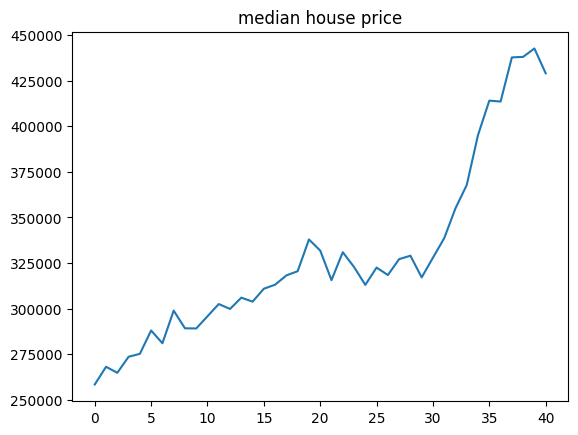

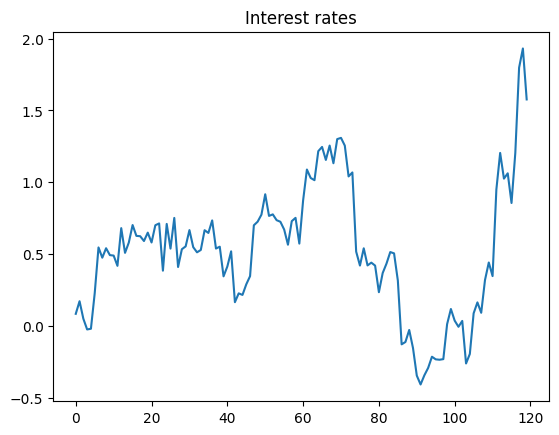

In [4]:
#check
controle = pd.read_csv("MSPUS.csv")
controle2 = controle["MSPUS"]
plt.plot(controle2)
plt.title("median house price")
plt.show()
plt.close()
plt.plot(df3)
plt.title("Interest rates")
plt.show()
plt.close()

More options:

- Agents don't always buy a house in the next time step (chance) and they have a chance to step out of the market (renting for example)
- Budget and willingness to pay is based on factors like age and family size instead of random
- Agents are able to save money (increase budget) when not buying a house
- Agents who already have a house have a chance of of selling and a chance of buying a new house
- Different kind of houses that different people have preferences for

More visualizations:

- Average time to sell a house.
- Proportion of homeless people.
- Total transaction volume per step.
- Histogram of house prices.